In [1]:
from pymarketng.application.Mechanism import *
from pymarketng.application.Utils import *
from pymarketng.application.BidsManager import BidsManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph
from pymarketng.application.Market import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
from typing import Callable, List, Type


### Load Dataset

In [2]:
# raw_df1 = pd.read_csv('datasets/20/final_df_type1.csv')
# raw_df2 = pd.read_csv('datasets/20/final_df_type2.csv')
# raw_df3 = pd.read_csv('datasets/20/final_df_type3.csv')
raw_df1 = pd.read_csv('datasets/all/final_df.csv')
# raw_df.fillna(0, inplace=True)
# raw_df1.dropna(inplace=True)
# raw_df2.dropna(inplace=True)
# raw_df3.dropna(inplace=True)

# TODO: drop is_seller nans
raw_df1

/tmp/ipykernel_24081/1864125201.py:4: DtypeWarning: Columns (8,21,34,47,60,73,86,99,112,125) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df1 = pd.read_csv('datasets/all/final_df.csv')


,time,type_user0,load_user0,generate_user0,SOC_user0,unit_user0,p_unit_user0,price_user0,is_seller_user0,is_peak_user0,...,matched_price_user28,matched_unit_user28,type_user29,load_user29,unit_user29,p_unit_user29,price_user29,is_peak_user29,matched_price_user29,matched_unit_user29
0,4/5/2013 0:00,3,401.000000,0.0,0.000000,401.000000,15.334469,6149.121928,False,False,...,NaN,0,1,1614.0,1614.0,15.283673,24667.848180,False,NaN,0
1,4/5/2013 1:00,3,374.000000,0.0,0.000000,374.000000,15.420419,5767.236818,False,False,...,NaN,0,1,564.0,564.0,15.284059,8620.209544,False,NaN,0
2,4/5/2013 2:00,3,511.000000,0.0,0.000000,511.000000,15.434803,7887.184121,False,False,...,NaN,0,1,485.0,485.0,15.281372,7411.465521,False,NaN,0
3,4/5/2013 3:00,3,370.000000,0.0,0.000000,370.000000,15.396081,5696.550084,False,False,...,NaN,0,1,611.0,611.0,15.309761,9354.264100,False,NaN,0
4,4/5/2013 4:00,3,281.000000,0.0,0.000000,281.000000,15.381224,4322.123976,False,False,...,NaN,0,1,556.0,556.0,15.339773,8528.913518,False,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25915,3/19/2016 19:00,3,469.000000,0.0,35.587845,14.929645,13.253146,197.864759,True,True,...,NaN,0,1,958.0,958.0,15.501363,14850.305350,True,NaN,0
25916,3/19/2016 20:00,3,503.000000,0.0,11.391363,275.172749,15.337520,4220.467519,False,True,...,NaN,0,1,1241.0,1241.0,15.340688,19037.794260,True,NaN,0
25917,3/19/2016 21:00,3,679.000000,0.0,0.000000,679.000000,15.266566,10365.998360,False,True,...,NaN,0,1,1448.0,1448.0,15.514686,22465.264620,True,NaN,0
25918,3/19/2016 22:00,3,502.000000,0.0,0.000000,502.000000,15.115549,7588.005398,False,False,...,NaN,0,1,1439.0,1439.0,14.603599,21014.578880,False,NaN,0


In [3]:
# r = [raw_df1, raw_df2, raw_df3]
r = [raw_df1]
# Converting the shape of df to a simpler form (creating all_bids df)
new_list=[]
for raw_df in r:
    number_of_users = len([col for col in raw_df.columns if col.startswith('type')])
    first_user_num = int(''.join(filter(str.isdigit, raw_df.columns[1])))
    for i in range(first_user_num, first_user_num + number_of_users):
        bid = {
            "time":raw_df['time'],
            "is_peak":raw_df[f'is_peak_user{i}'],
            "load":raw_df[f'load_user{i}'],
            "generate":raw_df[f'generate_user{i}'] if f'generate_user{i}' in raw_df.columns else None,
            "SOC":raw_df[f'SOC_user{i}'] if f'SOC_user{i}' in raw_df.columns else None,
            'unit':raw_df[f'unit_user{i}'],
            "price":raw_df[f'price_user{i}'],
            "is_seller":raw_df[f'is_seller_user{i}'].astype(bool) if f'is_seller_user{i}' in raw_df.columns else False,
            "user": i,
            "type": raw_df[f'type_user{i}']
        }
        new_list.append(pd.DataFrame(bid))
df = pd.concat(new_list)

# drop bids with unit == 0 or price == 0
df = df[df['unit'] != 0]
df = df[df['price'] != 0]

# parsing the time
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour

# calculate price per unit
df['price'] = df['price'] / df['unit']

# compatability
df['is_buying'] = ~df['is_seller']

#
# df.loc[df['is_seller'] == True, 'unit'] *= 1.5
# df.loc[df['is_seller'] == True, 'unit'] += 200

# df.loc[df['is_seller'] == False, 'price'] *= 1.0
# df.loc[df['is_seller'] == False, 'unit'] += 200

df.reset_index(drop=True,inplace=True)
df

/tmp/ipykernel_24081/3092724005.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(new_list)


,time,is_peak,load,generate,SOC,unit,price,is_seller,user,type,hour,is_buying
0,2013-04-05 00:00:00,False,401.0,0.0,0.0,401.0,15.334469,False,0,3,0,True
1,2013-04-05 01:00:00,False,374.0,0.0,0.0,374.0,15.420419,False,0,3,1,True
2,2013-04-05 02:00:00,False,511.0,0.0,0.0,511.0,15.434803,False,0,3,2,True
3,2013-04-05 03:00:00,False,370.0,0.0,0.0,370.0,15.396081,False,0,3,3,True
4,2013-04-05 04:00:00,False,281.0,0.0,0.0,281.0,15.381224,False,0,3,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
774603,2016-03-19 19:00:00,True,958.0,NaN,NaN,958.0,15.501363,False,29,1,19,True
774604,2016-03-19 20:00:00,True,1241.0,NaN,NaN,1241.0,15.340688,False,29,1,20,True
774605,2016-03-19 21:00:00,True,1448.0,NaN,NaN,1448.0,15.514686,False,29,1,21,True
774606,2016-03-19 22:00:00,False,1439.0,NaN,NaN,1439.0,14.603599,False,29,1,22,True


In [4]:
# split sellers and buyers to different dataframes
buyers_df = df[df['is_seller'] == False]
sellers_df = df[df['is_seller'] == True]

In [5]:
d_b = buyers_df.groupby('time').agg({'unit': 'sum'}).reset_index()
d_s = sellers_df.groupby('time').agg({'unit': 'sum'}).reset_index()
merged_df = pd.merge(d_b,d_s, on='time', how='inner',suffixes=('_buyers', '_sellers') )
merged_df.to_csv('units_df.csv', index=False, header=True, sep=',', encoding='utf-8')
merged_df['unit_buyers'] - merged_df['unit_sellers']

0         7568.097024
1         -272.348922
2       -13956.663227
3       -19096.927452
4       -19418.212837
             ...     
25865    17065.643676
25866    16129.138260
25867    18538.293355
25868    25999.925045
25869    15480.605116
Length: 25870, dtype: float64

In [6]:
time_list = df['time'].unique()
len(time_list)

25920

### Max and Min Price

In [7]:
Min_price_seller = sellers_df['price'].min()
Max_price_seller = sellers_df['price'].max()
Min_price_buyer = buyers_df[buyers_df['price'] > 0]['price'].min()
Max_price_buyer = buyers_df['price'].max()
print('Max_price_buyer:',Max_price_buyer)
print('Min_price_buyer',Min_price_buyer)
print('Max_price_seller:',Max_price_seller)
print('Min_price_seller',Min_price_seller)
p_feat = 11.3
p_G = 16.68

Max_price_buyer: 16.381115238623753
Min_price_buyer 14.498141259615384
Max_price_seller: 13.983934236357472
Min_price_seller 11.799999992884944


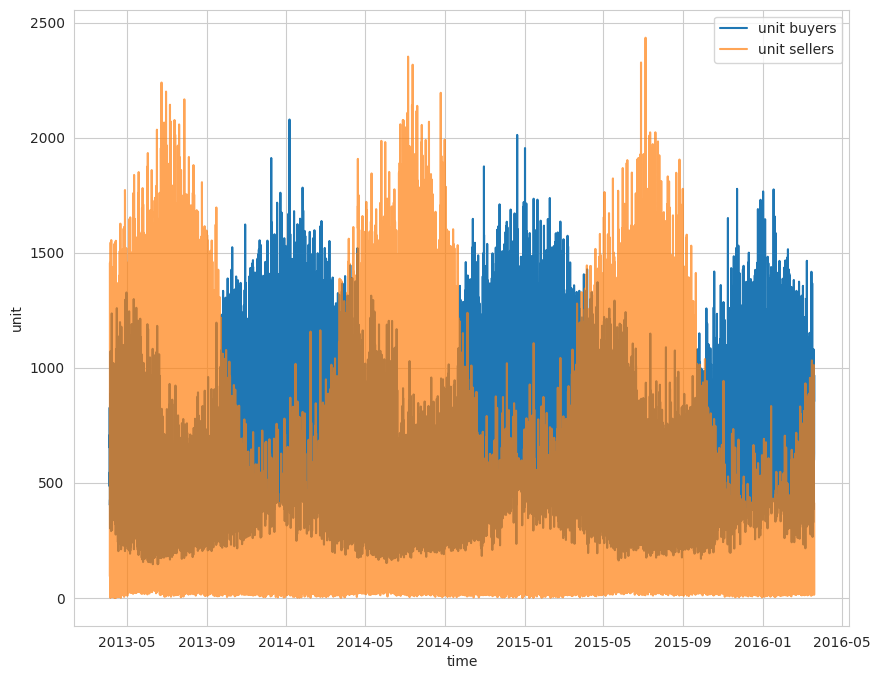

In [12]:
# TODO: move to lib
# TODO: needs update

# Define the start date and end date for the 7-day range
end_date = pd.to_datetime('2013-04-07')  # Example end date
start_date_week = end_date - pd.Timedelta(days=7)  # 7 days before the end date
start_date_3 = end_date - pd.Timedelta(days=3)  # 7 days before the end date

d_b = buyers_df.groupby('time').agg({'generate': 'mean', 'unit': 'mean', 'price': 'mean'}).reset_index()
d_s = sellers_df.groupby('time').agg({'generate': 'mean', 'unit': 'mean', 'price': 'mean'}).reset_index()

# Filter the DataFrame for the date range
buyers_df_week = buyers_df[(buyers_df['time'] >= start_date_week) & (buyers_df['time'] <= end_date)]
sellers_df_week = sellers_df[(sellers_df['time'] >= start_date_week) & (sellers_df['time'] <= end_date)]
buyers_df_3 = buyers_df[(buyers_df['time'] >= start_date_3) & (buyers_df['time'] <= end_date)]
sellers_df_3 = sellers_df[(sellers_df['time'] >= start_date_3) & (sellers_df['time'] <= end_date)]
df_3 = df[(df['time'] >= start_date_3) & (df['time'] <= end_date)]

# # Overall view of sellers and buyers
sns.set_style("whitegrid")
# # Create the plot
# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
plt.figure(figsize=(10, 8))
# plt.suptitle('Overall view of buyers and sellers units over 3 years', fontsize=18)

# d_b = buyers_df.groupby('time').agg({'unit': 'mean', 'price': 'mean'}).reset_index()
# sns.lineplot(data=d, x='time', y='price', label='price', ax=axs[0])
sns.lineplot(data=d_b, x='time', y='unit', label='unit buyers')
# sns.lineplot(data=d_b, x='time', y='generate', label='generate', ax=axs[0])
# axs[0].legend()

# d_s = sellers_df.groupby('time').agg({'unit': 'mean', 'price': 'mean'}).reset_index()
# sns.lineplot(data=d, x='time', y='price', label='price', ax=axs[1])
sns.lineplot(data=d_s, x='time', y='unit', label='unit sellers', alpha=0.7)
# sns.lineplot(data=d_s, x='time', y='generate', label='generate', ax=axs[1])
# axs[0].set_title('sellers')
# axs[0].legend()

plt.savefig('buyers_sellers_unit.pdf', dpi=2000, bbox_inches='tight')  # Adjust layout to make room for rotated labels

Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.9166666

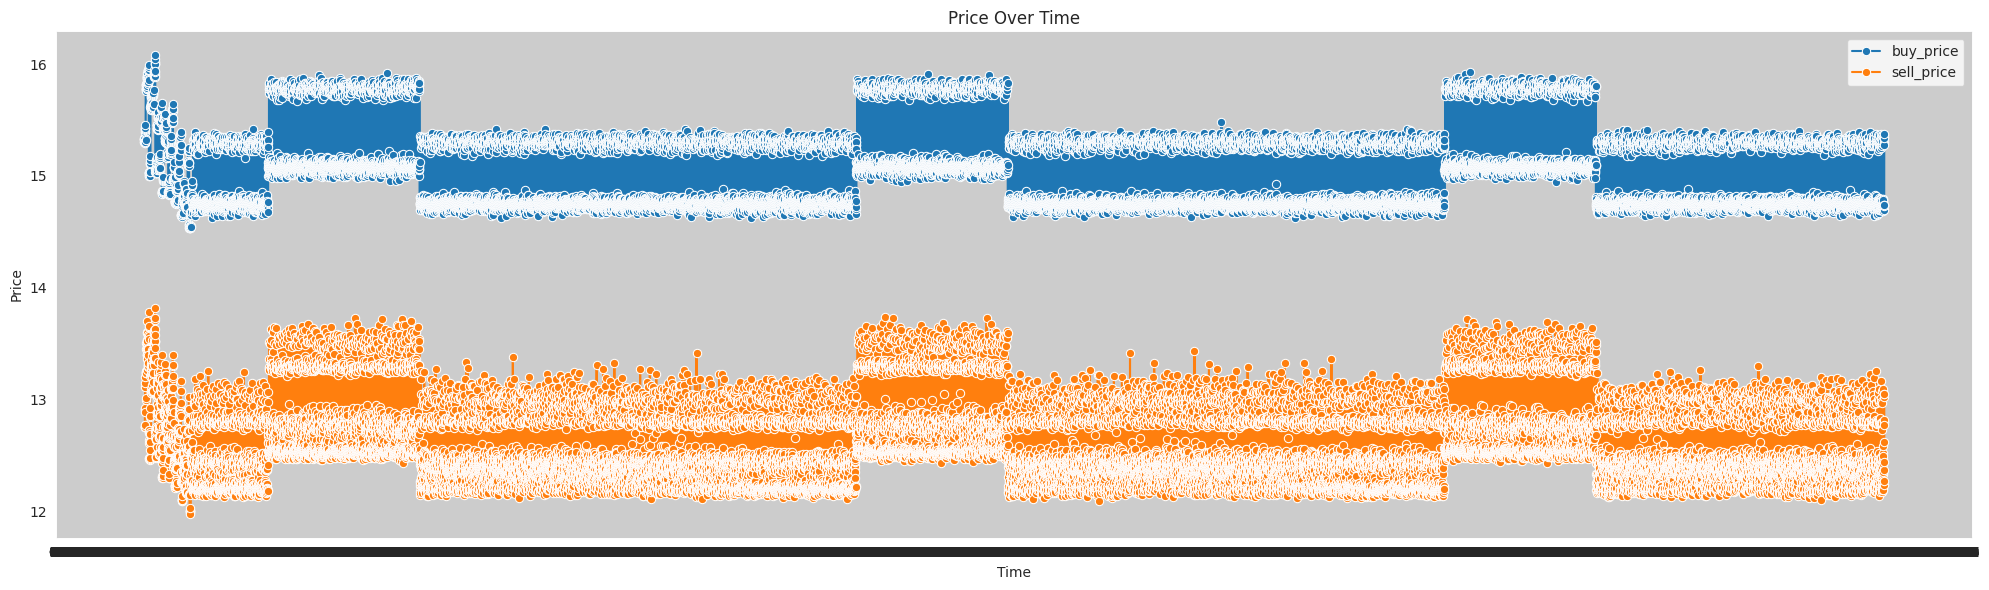

Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.9166666

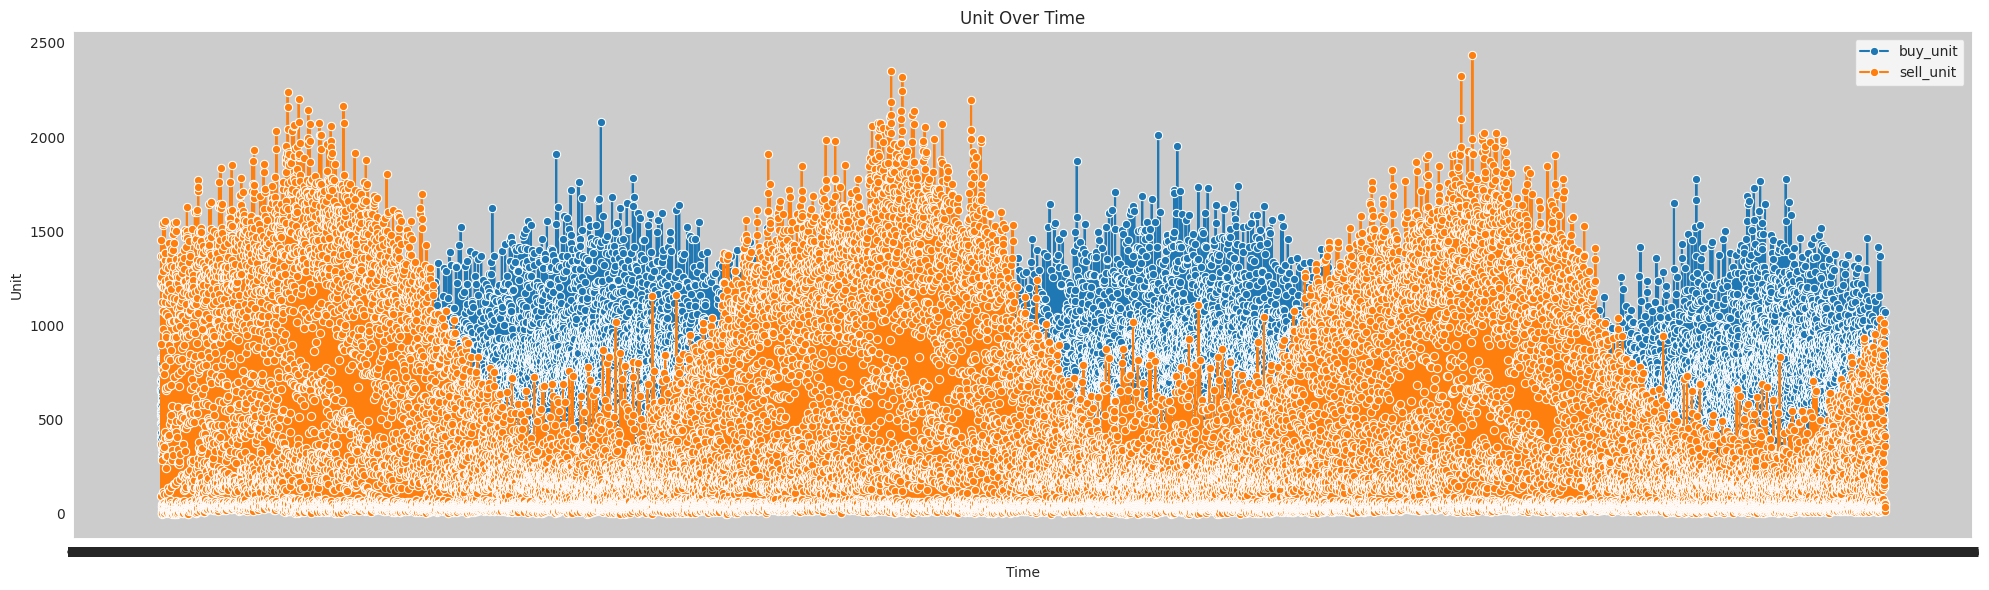

In [17]:
# TODO: move to library
import matplotlib.dates as mdates

sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=d_b, x='time', y='price', marker='o', label='buy_price')
sns.lineplot(data=d_s, x='time', y='price', marker='o', label='sell_price')
plt.title('Price Over Time')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlabel('Time')
plt.ylabel('Price')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=d_b, x='time', y='unit', marker='o', label='buy_unit')
sns.lineplot(data=d_s, x='time', y='unit', marker='o', label='sell_unit')
plt.title('Unit Over Time')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlabel('Time')
plt.ylabel('Unit')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


# buyers_df_3['diff'] = sellers_df_3['unit'] - buyers_df_3['unit']
# sns.set_style("whitegrid")
# plt.figure(figsize=(20, 6))
# sns.lineplot(data=buyers_df_3, x='time', y='diff', marker='o', label='buy_unit')
# plt.title('diff between buyers unit and sellers unit Over Time')
# plt.xlabel('Time')
# plt.ylabel('Unit')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.legend()
# plt.tight_layout()  # Adjust layout to make room for rotated labels
# plt.show()



In [10]:
merged = pd.merge(d_b, d_s, on='time', suffixes=('_b', '_s'))
merged[merged['price_b'] > merged['price_s']].reset_index(drop=True)

,time,generate_b,unit_b,price_b,generate_s,unit_s,price_s
0,2013-04-05 07:00:00,815.520987,482.773697,15.331649,318.651845,70.790733,12.646292
1,2013-04-05 08:00:00,2929.633941,610.145535,15.335608,754.871408,259.850574,12.653041
2,2013-04-05 09:00:00,5045.424127,550.694314,15.347465,1077.412434,494.800190,12.656468
3,2013-04-05 10:00:00,NaN,557.403509,15.328831,1211.890698,676.190698,12.641141
4,2013-04-05 11:00:00,NaN,497.701754,15.324902,1449.561492,806.061492,12.640222
...,...,...,...,...,...,...,...
702,2013-05-04 19:00:00,157.403568,559.529559,15.004040,103.901814,49.762496,12.698417
703,2013-05-04 20:00:00,0.000000,1192.794801,15.021881,0.000000,40.987332,12.693822
704,2013-05-04 21:00:00,0.000000,1017.746606,15.021199,0.000000,188.303307,12.805767
705,2013-05-04 22:00:00,0.000000,961.435010,14.848944,0.000000,197.259597,12.536046


Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.916666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 28510 ticks ([15746.041666666666, ..., 16933.9166666

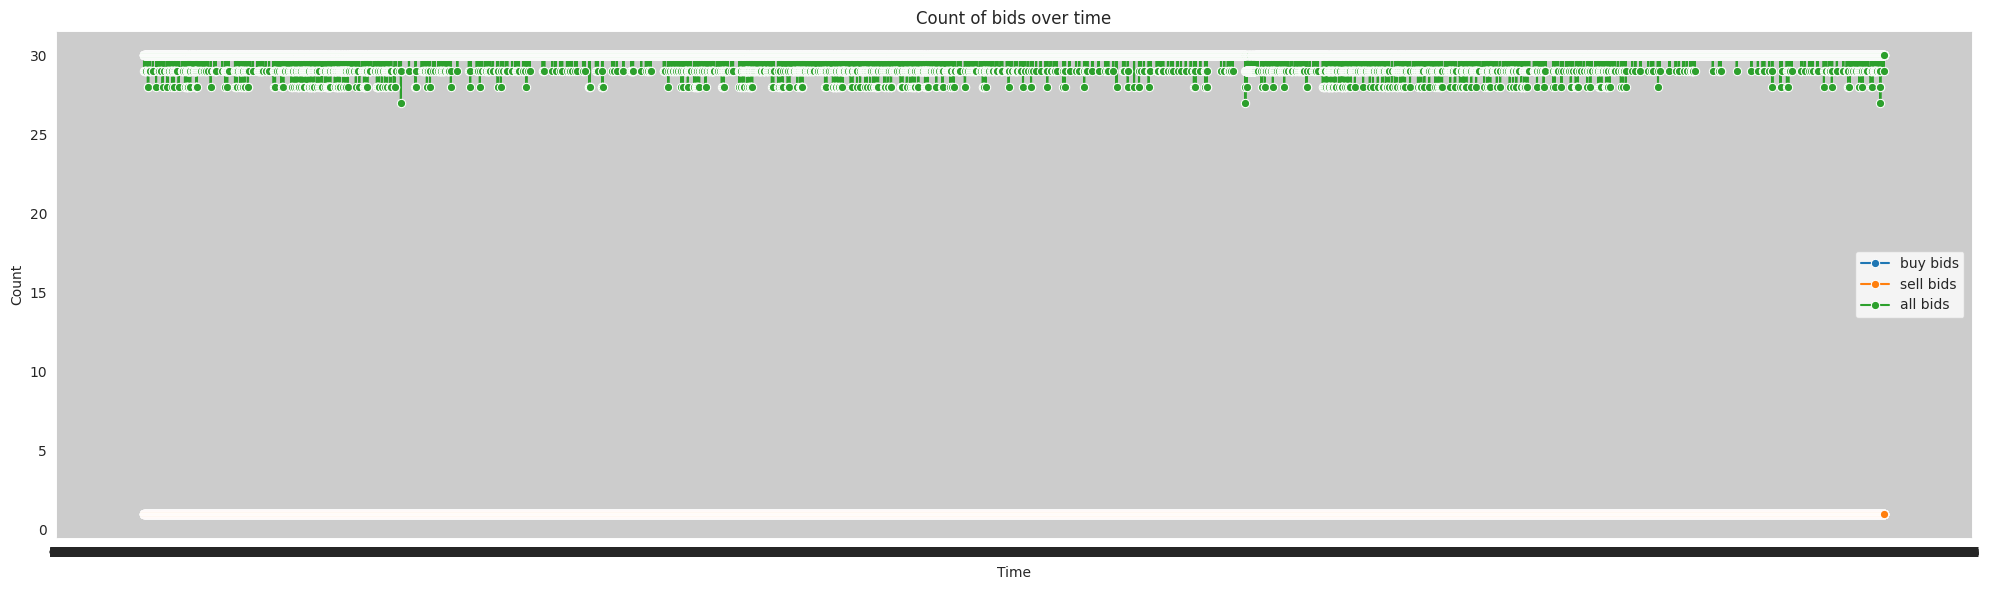

In [18]:
# TODO: move to library

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
buyers_bids_count = d_b.groupby('time').size().reset_index(name='count')
sellers_bids_count = d_s.groupby('time').size().reset_index(name='count')
all_bids_count = df.groupby('time').size().reset_index(name='count')
sns.lineplot(data=buyers_bids_count, x='time', y='count', marker='o', label='buy bids')
sns.lineplot(data=sellers_bids_count, x='time', y='count', marker='o', label='sell bids')
sns.lineplot(data=all_bids_count, x='time', y='count', marker='o', label='all bids')

# Add titles and labels
plt.title('Count of bids over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()

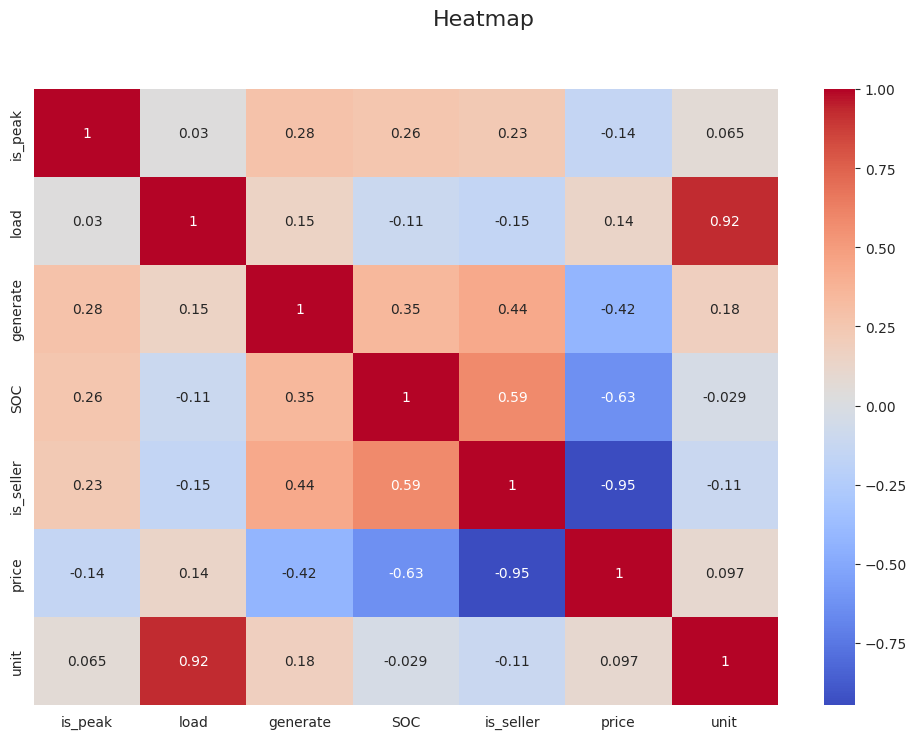

In [12]:
numerical_columns = ['is_peak', 'load', 'generate','SOC','is_seller', 'price', 'unit']
# numerical_columns = ['is_peak', 'is_seller', 'price', 'unit']
plt.figure(figsize=(12, 8))
plt.suptitle('Heatmap', fontsize=16)
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.show()